In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA
from utils import *

In [3]:
# reading the dataset
data = pd.read_csv('./data/MI_timesteps.txt',sep=' ', skiprows=range(1,1001))

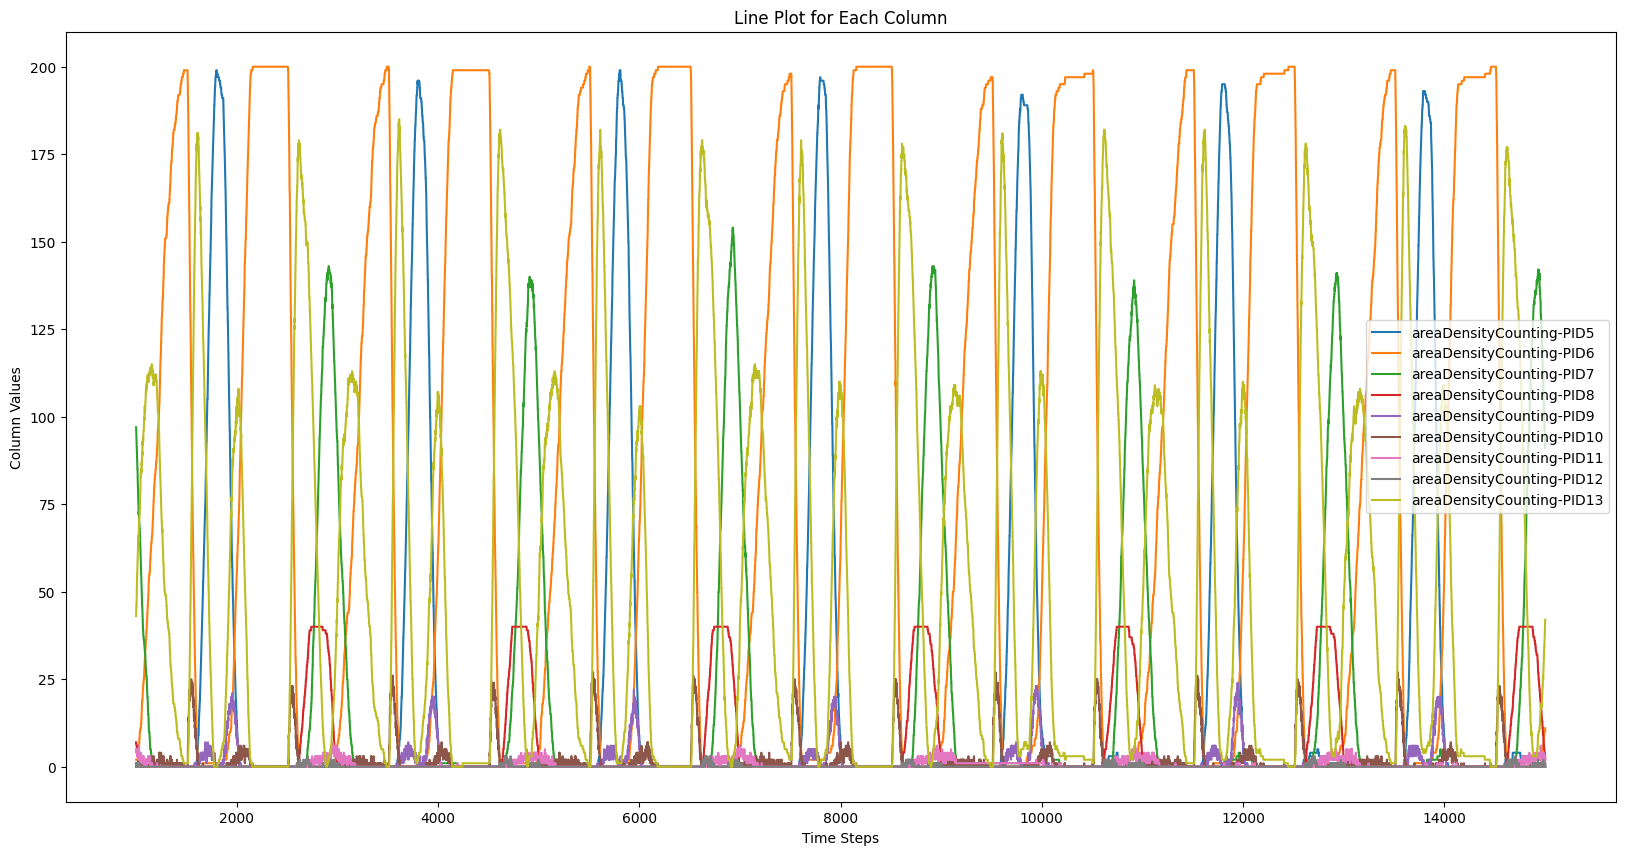

In [4]:
fig = plt.figure(figsize=(20,10))
for column in data.columns[1:]:
    plt.plot(data['timeStep'], data[column], label=column)

plt.xlabel('Time Steps')
plt.ylabel('Column Values')
plt.title('Line Plot for Each Column')
plt.legend()

In [5]:
# function for creating delay embeddings
def create_delay_embedding(data, delay):
    n_rows = len(data) - delay
    embedded_data = np.zeros((n_rows, (delay + 1)*3))

    for i in range(n_rows):
        embedded_data[i] = data.iloc[i:i + delay + 1,1:4].values.flatten()

    return embedded_data

### Part 5.1

In [6]:
window_matrix = create_delay_embedding(data,350)
window_matrix.shape

(13651, 1053)

In [7]:
pca = PCA(n_components=3)  # Adjust the number of components if necessary
pca_result = pca.fit_transform(window_matrix)
pca_result.shape

(13651, 3)

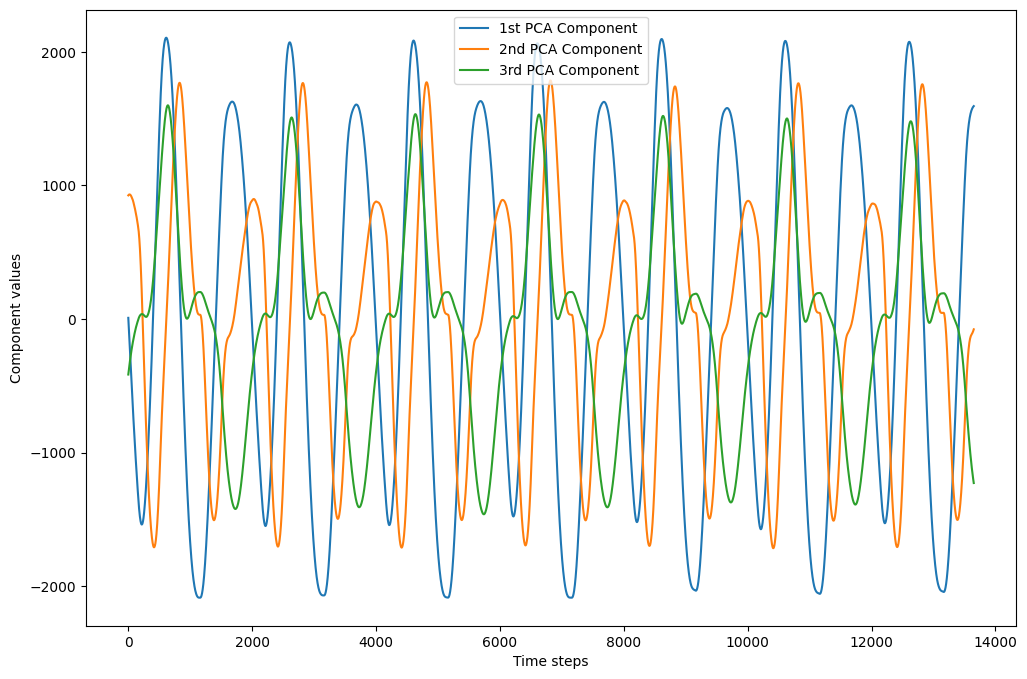

In [8]:
# Plotting pca components
plt.figure(figsize=(12, 8))
plt.plot(range(len(pca_result)),pca_result[:,0], label="1st PCA Component")
plt.plot(range(len(pca_result)),pca_result[:,1], label="2nd PCA Component")
plt.plot(range(len(pca_result)),pca_result[:,2], label="3rd PCA Component")
plt.xlabel('Time steps')
plt.ylabel('Component values')
plt.legend(loc='upper center')

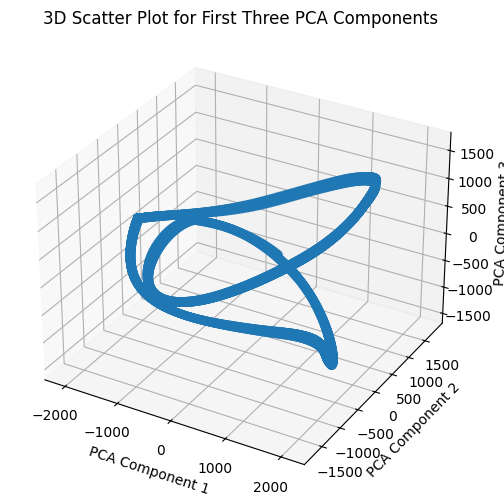

In [9]:
# prepare
x_original = window_matrix[:, :9]  
X_pca = pca_result

# 3D scatter plot for the first three PCA components
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2])
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('3D Scatter Plot for First Three PCA Components')
plt.show()


### Part 5.2

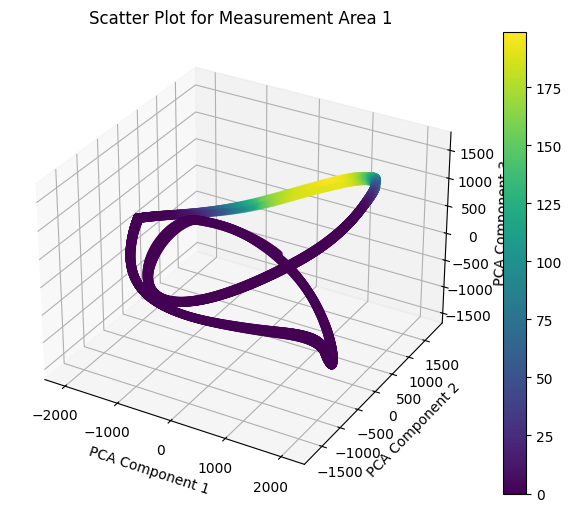

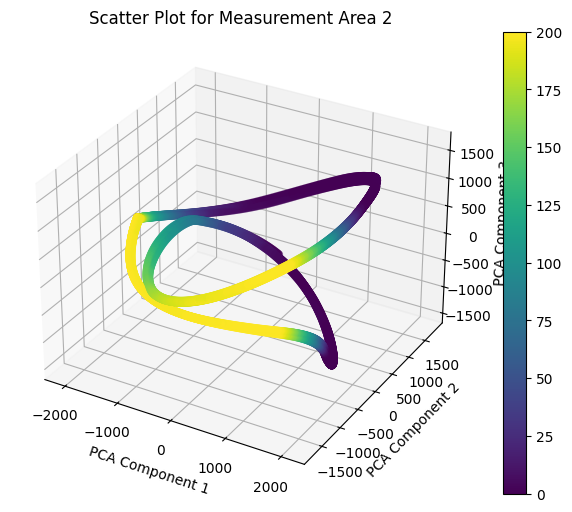

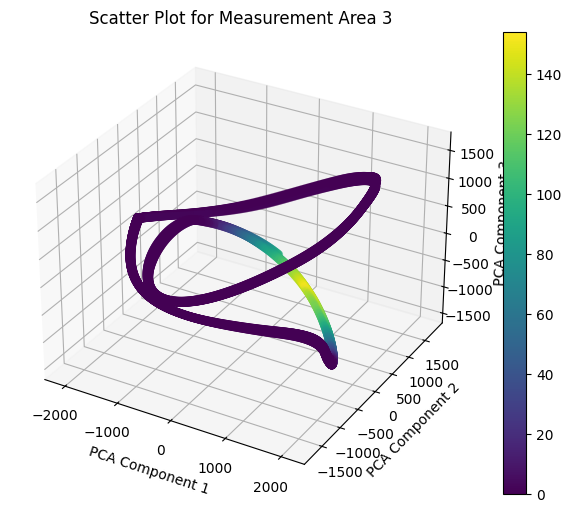

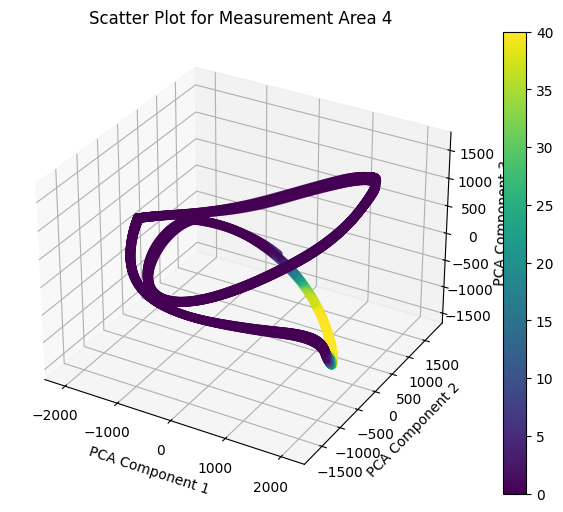

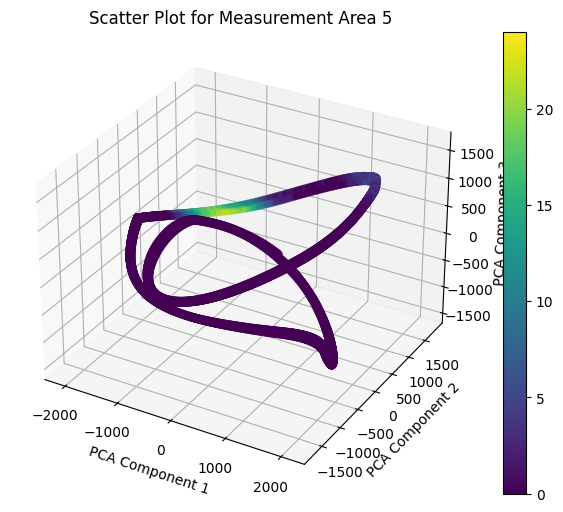

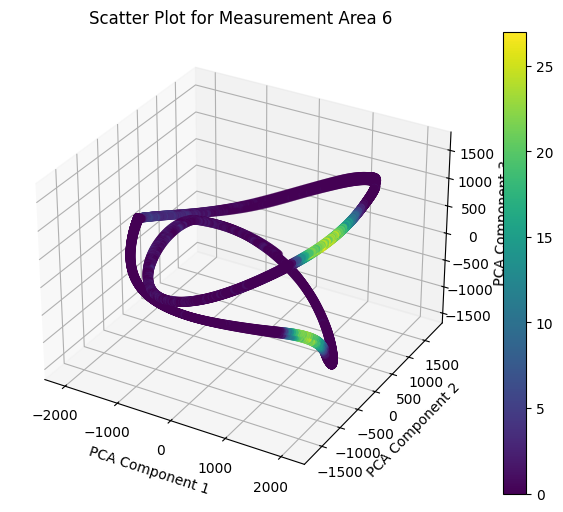

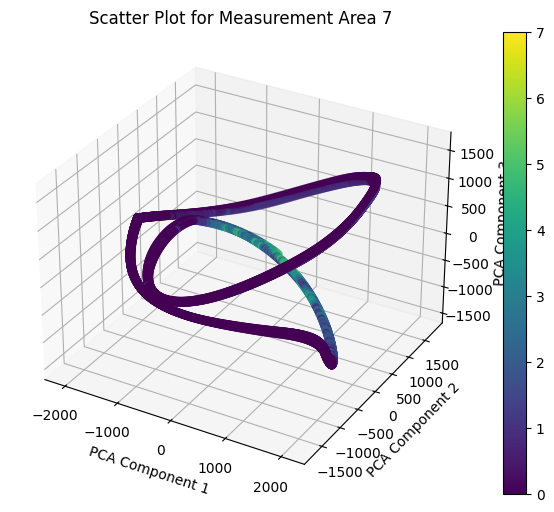

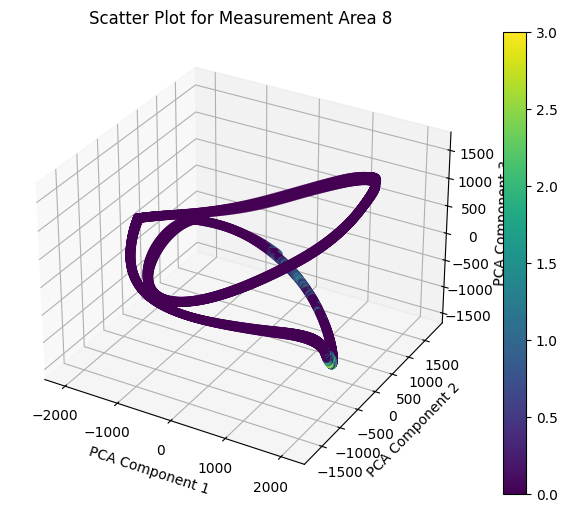

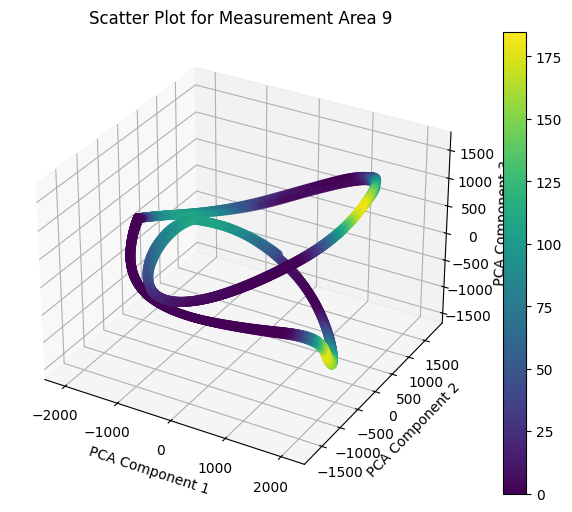

In [10]:
#skipping 1st column which is timestamp
for i in range(1,10):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Adjust the scatter plot with three components (x, y, z)
    scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=data.iloc[:len(pca_result), i])
    
    plt.colorbar(scatter)
    ax.set_title(f'Scatter Plot for Measurement Area {i}')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')

    plt.show()


### Part 5.3

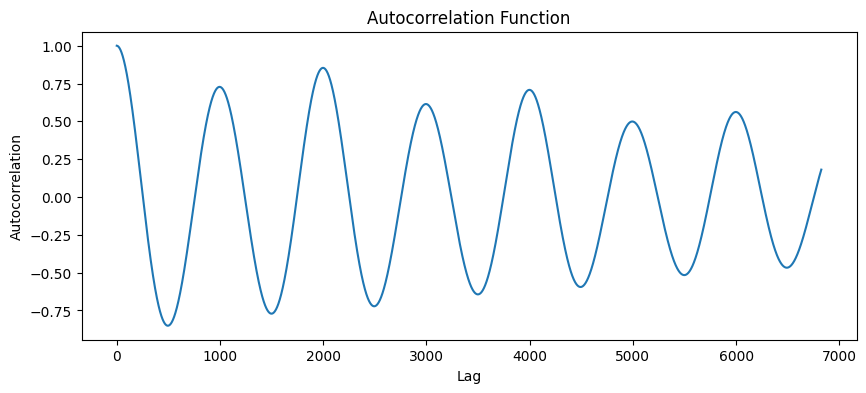

In [24]:
from statsmodels.tsa.stattools import acf

component = X_pca[:, 0]
# Compute the autocorrelation function 
autocorr = acf(component, fft=True, nlags=len(component)//2)
plt.figure(figsize=(10, 4))
plt.plot(autocorr)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')
plt.show()

# Create a generator expression to calculate distances and filter out artifacts
threshold_distance = 100.0
start_index = 100
distances = ((i, np.linalg.norm(point - X_pca[start_index])) for i, point in enumerate(X_pca) if i > start_index)

try:
    lowest_dist_idx, lowest_dist = min(distances, key=lambda x: x[1])
except ValueError:
    lowest_dist_idx, lowest_dist = -1, np.inf

In [25]:
arclens = []  # Save arclens at every time step
speeds = []  # Save speed related to arclens
cum_arclen = 0  # Variable to accumulate arclen value

for i in range(X_pca.shape[0] - 1):
    if i != 0 and i % lowest_dist_idx == 0:
        # If the period end is met, reset the cumulative arclength
        cum_arclen = 0
    # Calculate the incremental arclength by L2-norm
    cum_arclen += np.linalg.norm(X_pca[i+1] - X_pca[i])
    # Get the time step within the current period
    dt = (i % lowest_dist_idx) + 1
    arclens.append(cum_arclen)
    speeds.append(cum_arclen / dt)

# Normalize the arclength for visualization
normalized_arclength = np.array(arclens) / max(arclens) * 2 * np.pi

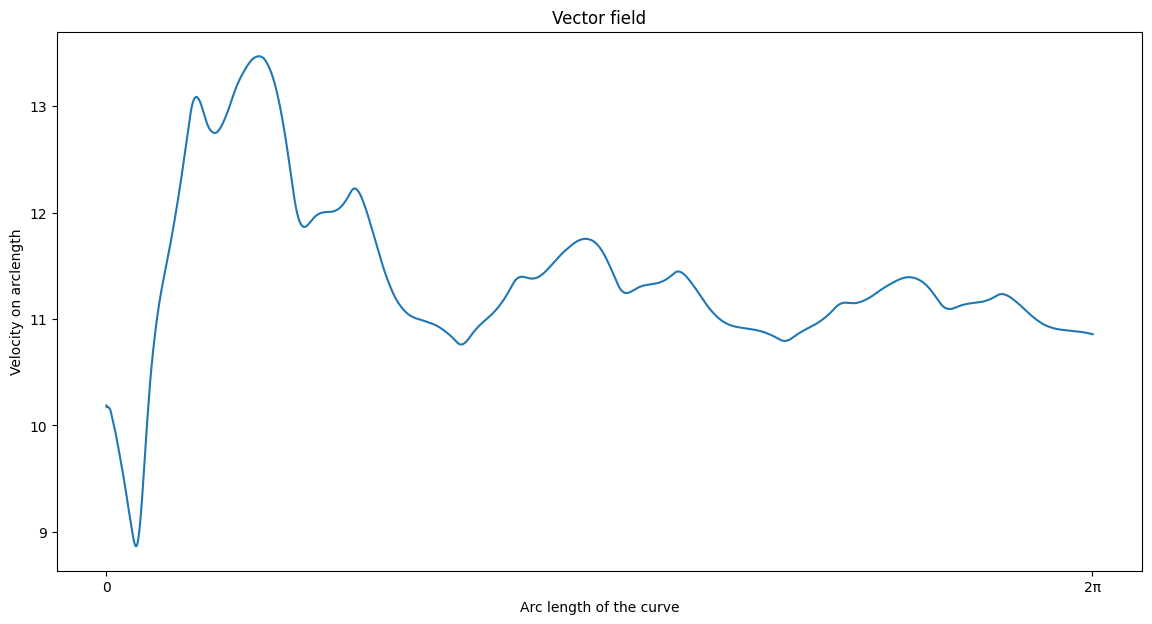

In [26]:
period_speeds = speeds[:lowest_dist_idx]
period_speeds_x = [i * 2 * math.pi / len(period_speeds) for i in range(len(period_speeds))]  
plt.plot(period_speeds_x, period_speeds)
plt.title("Vector field")
plt.xticks([0, 6.28], ['0', '2π'], rotation='horizontal')
plt.xlabel('Arc length of the curve')
plt.ylabel('Velocity on arclength')
plt.show()

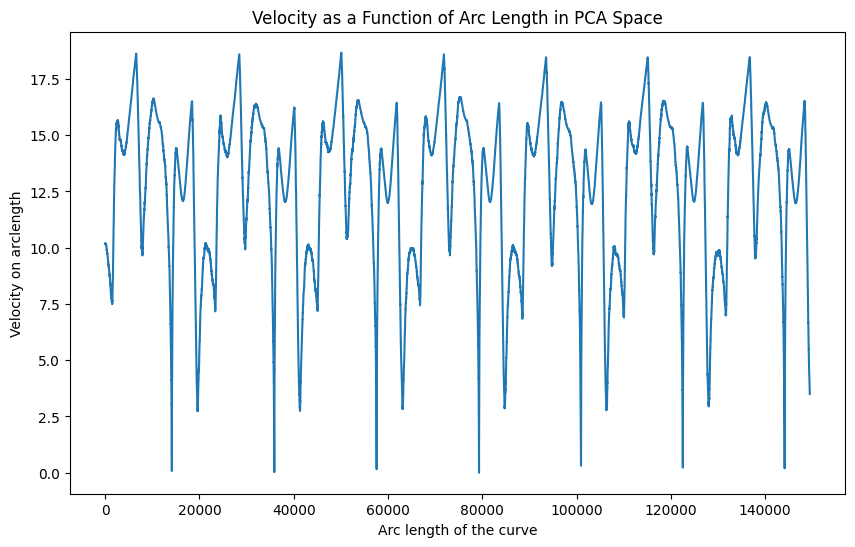

In [ ]:
time_steps = data.iloc[:,0]
# Calculating the distances (deltas) between consecutive points
deltas = np.diff(X_pca, axis=0)

# Calculating the arclength between consecutive points
arclengths = np.linalg.norm(deltas, axis=1)

# Computing the total arclength at each point
total_arclength = np.cumsum(arclengths)

# Finding time differences between two consecutive points
time_deltas = np.diff(time_steps[:len(X_pca)])

# Compute the velocity: change in arclength over change in time
velocities = arclengths / time_deltas

# Plotting velocity against total arclength
plt.figure(figsize=(10, 6))
plt.plot(total_arclength, velocities)
plt.xlabel('Arc length of the curve')
plt.ylabel('Velocity on arclength')
plt.title('Velocity as a Function of Arc Length in PCA Space')
plt.show()


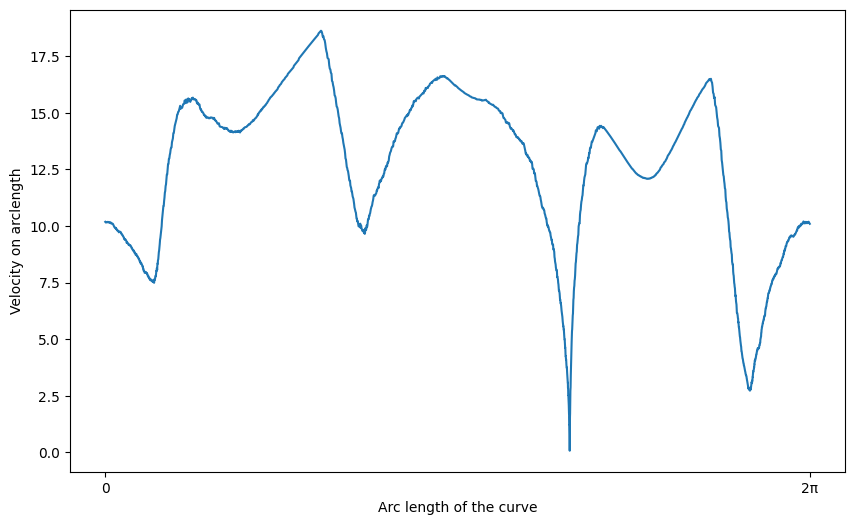

In [ ]:
#Since dataset is periodic and of 7 days, we can extract one period length
period_length = int(len(total_arclength)/7)
plt.figure(figsize=(10, 6))
plt.plot(total_arclength[:period_length], velocities[:period_length])
plt.xticks([total_arclength[0], total_arclength[period_length-1]], ['0', '2π'])
plt.xlabel('Arc length of the curve')
plt.ylabel('Velocity on arclength')
plt.show()


### Task 5.4

In [ ]:
#extending velocities and time for 14 days
extrapolated_velocities = np.tile(velocities, 2)
extended_time_deltas = np.tile(time_deltas,2)

Text(0.5, 1.0, 'First measurement area')

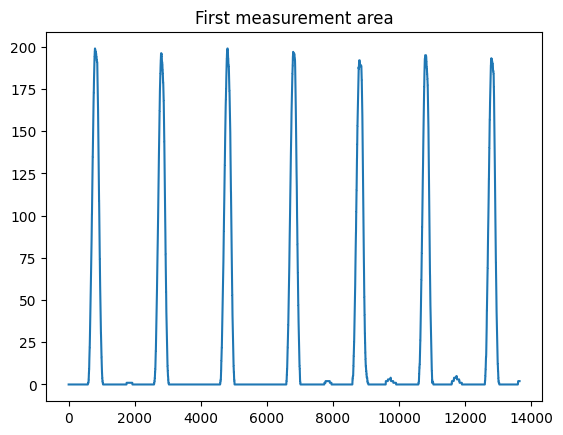

In [ ]:
# first observation field
y = data.iloc[:len(X_pca)-1,1]
plt.plot(y)
plt.title("First measurement area")

In [ ]:
# integrated_arclengths for 14 days
integrated_arclengths = np.cumsum(extrapolated_velocities * extended_time_deltas)

In [ ]:
# extrapolating y for 14 days
y_extrapolated = np.tile(y,2)

In [ ]:
l = 2000  
eps = 5

# Apply radial basis functions to the integrated arclengths
phi = radial_basis_function(integrated_arclengths, l, eps)
C = least_squares_minimization(phi.T,y_extrapolated,None)
f_hat = phi.T @ C

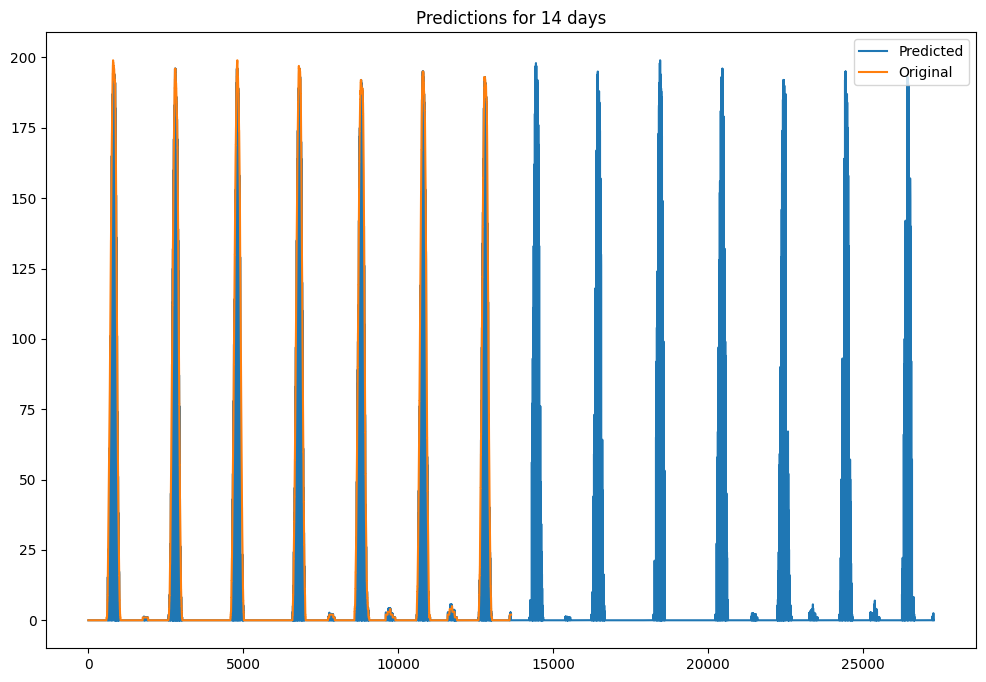

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(y)*2), f_hat, label="Predicted")
plt.plot(range(len(y)), y, label="Original")
plt.legend(loc='upper right')
plt.title("Predictions for 14 days")
plt.show()